In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pathlib

In [3]:
dataset_url='/content/drive/MyDrive/plant_leaf_dataset/small_dataset3/'

In [4]:
dataset_dir=pathlib.Path(dataset_url)
dataset_dir

PosixPath('/content/drive/MyDrive/plant_leaf_dataset/small_dataset3')

In [5]:
dataset_dict={
    'Apple':list(dataset_dir.glob('Apple/*JPG')),
    'Blueberry':list(dataset_dir.glob('Blueberry/*JPG')),
    'Cherry':list(dataset_dir.glob('Cherry/*JPG')),
    'Grapes':list(dataset_dir.glob('Grapes/*JPG'))
}


In [6]:
dataset_label={
    'Apple':0,
    'Blueberry':1,
    'Cherry':2,
    'Grapes':3
}

In [7]:
len(dataset_dict['Cherry'])

1000

In [8]:
import torch
from PIL import Image

In [9]:
%%time
X,y=[],[]
count=0
for key in dataset_dict:
  for values in dataset_dict[key]:
    image=Image.open(values)
    X.append(image)
    y.append(dataset_label[key])
    count+=1
    if (count%100==0):
      print(f"{count} images added to the list")

100 images added to the list
200 images added to the list
300 images added to the list
400 images added to the list
500 images added to the list
600 images added to the list
700 images added to the list
800 images added to the list
900 images added to the list
1000 images added to the list
1100 images added to the list
1200 images added to the list
1300 images added to the list
1400 images added to the list
1500 images added to the list
1600 images added to the list
1700 images added to the list
1800 images added to the list
1900 images added to the list
2000 images added to the list
2100 images added to the list
2200 images added to the list
2300 images added to the list
2400 images added to the list
2500 images added to the list
2600 images added to the list
2700 images added to the list
2800 images added to the list
2900 images added to the list
3000 images added to the list
3100 images added to the list
3200 images added to the list
3300 images added to the list
3400 images added t

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
(X_train,X_test,y_train,y_test)=train_test_split(X,y,test_size=0.2,random_state=0)

In [12]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.utils.data.dataset import random_split

In [13]:
TOTAL_CLASSES = 4
NUM_EPOCHS = 20
batch_size = 32

In [14]:
from torchvision.models import shufflenet_v2_x0_5
model = torch.hub.load('pytorch/vision:v0.10.0', 'shufflenet_v2_x0_5', weights=None)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


In [15]:
num_classes = TOTAL_CLASSES #len(classification_class)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

In [16]:
##loss function cross entropy loss
criterion = nn.CrossEntropyLoss()

In [17]:
## Optimizer stocastic gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [18]:
#Making the dataset ready for taining out of x_train and y_train

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define your transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create your Dataset
dataset = CustomDataset(images=X_train, labels=y_train, transform=transform)

In [19]:
# Once the dataset is ready split the x_train, y_train dataset into training and validation dataset
# 80% for training 20% for validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, val_size])
print(len(train_dataset))
print(len(validation_dataset))

3294
824


In [20]:
# Create data loader to feed the CNN
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_dataset = CustomDataset(images=X_test, labels=y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [21]:
len(test_loader)

33

In [22]:
len(validation_loader)

26

In [23]:
len(train_loader)

103

In [24]:
train_loss_list=[]
validation_loss_list=[]
test_loss_list=[]
training_accuracy_list=[]
validation_accuracy_list=[]
test_accuracy_list=[]

In [25]:
epochs_list=[x for x in range(NUM_EPOCHS)]

In [26]:
epochs_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [27]:
import numpy as np

In [28]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
device

device(type='cuda')

In [ ]:
model.to(device)

In [33]:
# Iterate over the dataset
for epoch in range(NUM_EPOCHS):
    total=0
    correct=0
    batch=0

    accumulated_loss=0
    model.train()
    for images, labels in train_loader:
        images=images.to(device)
        labels=labels.to(device)
        # batch+=1
        # Forward pass
        outputs = model(images)
        # print(labels)
        # print('output........',outputs)
        # print('logits.......',logits)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accumulated_loss+=loss.cpu().detach().numpy().astype(np.float64)
        # print(accumulated_loss)
        # print(type(accumulated_loss))
        # if (batch%200==0):
        #   print(f'Accumulated train loss: {accumulated_train_loss} loop count: {inner_loop_counter_train}')
        #   print(f'Loss for {batch}/{len(train_loader)} of {epoch} epochs is: ',train_loss)
          # break
        # if(batch==2):
        #   break
    training_accuracy = correct / total
    training_accuracy_list.append(training_accuracy)
    print(f'EPOCH{epoch}....................')
    print('Accuracy on training set: {}%'.format(100 * training_accuracy))
    train_loss_list.append(accumulated_loss/len(train_loader))

    correct = 0
    total = 0
    accumulated_loss=0

    #Evaluation
    model.eval()
    with torch.inference_mode():
      for images, labels in validation_loader:
        images=images.to(device)
        labels=labels.to(device)
        outputs = model(images)
        loss=criterion(outputs,labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accumulated_loss+=loss.cpu().detach().numpy().astype(np.float64)

      validation_loss_list.append(accumulated_loss/len(validation_loader))
      validation_accuracy=correct/total
      print(f'EPOCH{epoch}.......')
      print('Accuracy on validation set: {}%'.format(100 * validation_accuracy))
      validation_accuracy_list.append(validation_accuracy)

print('training finished....')
from pathlib import Path
MODEL_PATH=Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)
MODEL_NAME="Dataset3_ShuffleNet.pth"
MODEL_SAVE_PATH=MODEL_PATH/MODEL_NAME
print(f"Model saving in...{MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),f=MODEL_SAVE_PATH)

EPOCH0....................
Accuracy on training set: 60.95931997571342%
EPOCH0.......
Accuracy on validation set: 73.7864077669903%
EPOCH1....................
Accuracy on training set: 85.09411050394658%
EPOCH1.......
Accuracy on validation set: 85.07281553398059%
EPOCH2....................
Accuracy on training set: 90.92289010321797%
EPOCH2.......
Accuracy on validation set: 79.36893203883496%
EPOCH3....................
Accuracy on training set: 92.56223436551305%
EPOCH3.......
Accuracy on validation set: 76.82038834951457%
EPOCH4....................
Accuracy on training set: 94.53551912568307%
EPOCH4.......
Accuracy on validation set: 92.35436893203884%
EPOCH5....................
Accuracy on training set: 96.50880388585307%
EPOCH5.......
Accuracy on validation set: 96.48058252427184%
EPOCH6....................
Accuracy on training set: 96.23557984213721%
EPOCH6.......
Accuracy on validation set: 95.02427184466019%
EPOCH7....................
Accuracy on training set: 97.60170006071645

In [34]:
correct = 0
total = 0
accumulated_loss=0
#Testing
model.eval()
y=[]
y_pred=[]
with torch.inference_mode():
  for images, labels in test_loader:
    images=images.to(device)
    labels=labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    y.extend((labels.cpu().numpy()))
    y_pred.extend((predicted.cpu().numpy()))
    test_accuracy=correct/total
    print(f'EPOCH{epoch}...................')
    print('Accuracy on test set: {}%'.format(100 * test_accuracy))
    test_accuracy_list.append(test_accuracy)

EPOCH19...................
Accuracy on test set: 93.75%
EPOCH19...................
Accuracy on test set: 95.3125%
EPOCH19...................
Accuracy on test set: 95.83333333333334%
EPOCH19...................
Accuracy on test set: 96.875%
EPOCH19...................
Accuracy on test set: 96.875%
EPOCH19...................
Accuracy on test set: 96.35416666666666%
EPOCH19...................
Accuracy on test set: 96.875%
EPOCH19...................
Accuracy on test set: 97.265625%
EPOCH19...................
Accuracy on test set: 97.56944444444444%
EPOCH19...................
Accuracy on test set: 97.8125%
EPOCH19...................
Accuracy on test set: 98.01136363636364%
EPOCH19...................
Accuracy on test set: 97.91666666666666%
EPOCH19...................
Accuracy on test set: 97.59615384615384%
EPOCH19...................
Accuracy on test set: 97.76785714285714%
EPOCH19...................
Accuracy on test set: 97.91666666666666%
EPOCH19...................
Accuracy on test set: 97.8

In [35]:
from sklearn.metrics import recall_score,precision_score,f1_score,confusion_matrix

In [36]:
recall=recall_score(y,y_pred,average=None)
precision=precision_score(y,y_pred,average=None)
f_score=f1_score(y,y_pred,average=None)
cm=confusion_matrix(y,y_pred)


In [37]:
print('Recall is : ',recall)
print('Precision is:',precision)
print('F1-Score is: ',f_score)

Recall is :  [0.95548961 0.99671053 1.         0.98979592]
Precision is: [0.99690402 0.95583596 0.98974359 0.99487179]
F1-Score is:  [0.97575758 0.97584541 0.99484536 0.99232737]


In [38]:
import seaborn as sns

In [40]:
import matplotlib.pyplot as plt

In [44]:
from google.colab import files

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

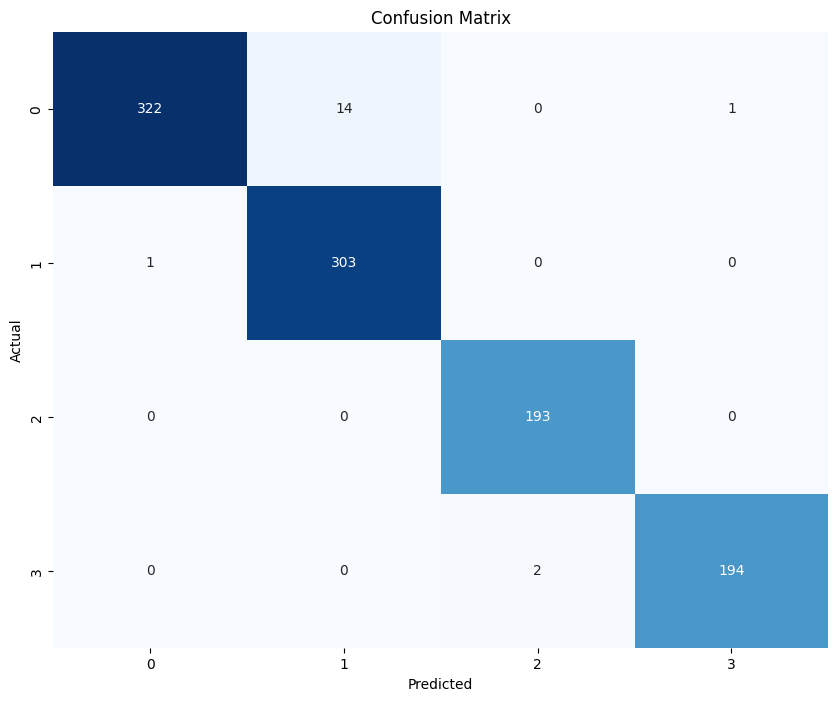

In [47]:
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('Dataset3_ShuffleNet_confusion_matrix.png')
files.download('Dataset3_ShuffleNet_confusion_matrix.png')
plt.show()

In [48]:
prediction_list=[]
labels_list=[]
with torch.inference_mode():
  for images, labels in test_loader:
    images=images.to(device)
    labels=labels.to(device)
    outputs = model(images)
    prediction_list.append(outputs.cpu())
    labels_list.append(labels.cpu())


In [49]:
prediction_all=torch.cat(prediction_list).numpy()
labels_all=torch.cat(labels_list).numpy()

In [52]:
from sklearn.manifold import TSNE

In [53]:
tsne=TSNE(n_components=2,random_state=42)
embedding_2d=tsne.fit_transform(prediction_all)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

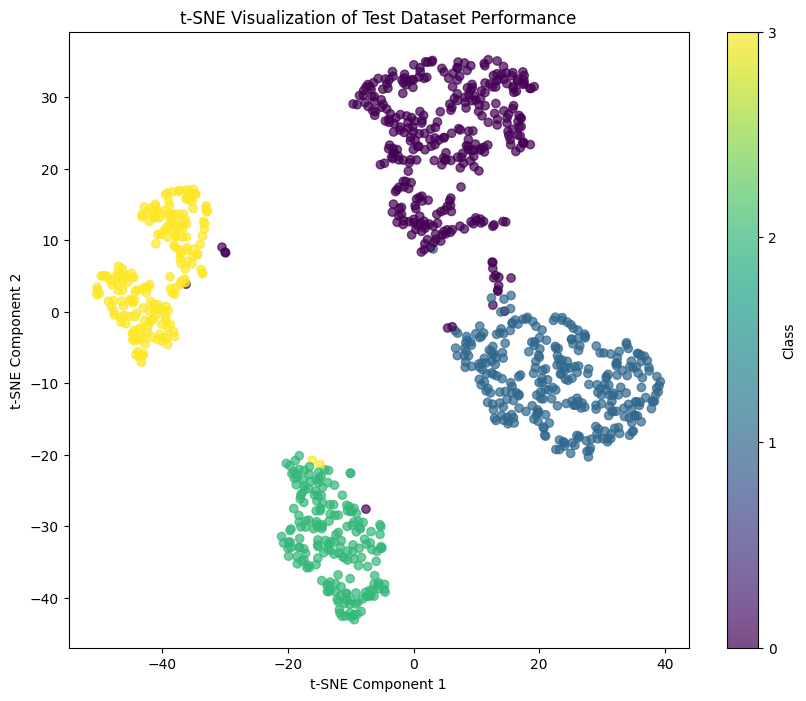

In [61]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=labels_all, cmap='viridis', alpha=0.7)
plt.colorbar(scatter,ticks=[0,1,2,3],label='Class')
plt.title('t-SNE Visualization of Test Dataset Performance')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.savefig('Dataset3_ShuffleNet_TSNE.png')
files.download('Dataset3_ShuffleNet_TSNE.png')
plt.show()

In [62]:
print(epochs_list)
print(train_loss_list)
print(validation_loss_list)
print(test_loss_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0.8824013162006452, 0.380516641637654, 0.26098855653578795, 0.20118530034946586, 0.15222503407632262, 0.10638235427113701, 0.1053416222623251, 0.06317130422436641, 0.06413640011129088, 0.04217741244983434, 0.033906039127456114, 0.04289446996402863, 0.02692061018320795, 0.03571439427391454, 0.02930762571394579, 0.018874509807945077, 0.037968756575352126, 0.013614706178557453, 0.04231936878268155, 0.028947206798548702]
[0.7678764657332346, 0.34274819779854554, 0.528597527398513, 0.8128660069062159, 0.22631510848609301, 0.110827109310776, 0.1367696879718166, 0.10026824705374356, 0.14245820976793766, 0.0634007858685576, 0.5672920604164784, 0.16029539169707838, 0.06923482771694231, 0.0661282172659412, 0.0923125554377643, 0.06806520906796393, 0.08647312859270292, 0.1400833348463773, 0.1022701237995464, 0.13261560381551346]
[]


In [ ]:
# import numpy as np
# numpy_training_loss_list=[tensor.detach().numpy().astype(np.float64) for tensor in train_loss_list]
# numpy_array_training_loss= np.array(numpy_training_loss_list)
# numpy_validation_loss_list=[tensor.detach().numpy().astype(np.float64) for tensor in validation_loss_list]
# numpy_array_validation_loss= np.array(numpy_validation_loss_list)
# numpy_test_loss_list=[tensor.detach().numpy().astype(np.float64) for tensor in test_loss_list]
# numpy_array_test_loss= np.array(numpy_test_loss_list)
# print(numpy_array_training_loss.shape,numpy_array_validation_loss.shape,numpy_array_test_loss.shape)

(1,) (1,) (1,)


In [63]:
epochs_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

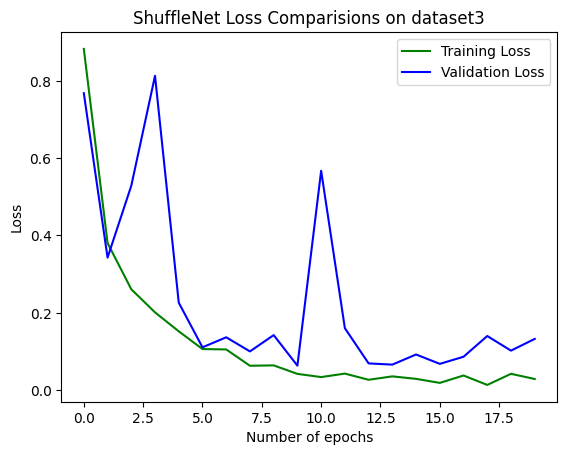

In [64]:
import matplotlib.pyplot as plt
from google.colab import files
fig,ax=plt.subplots()
ax.plot(epochs_list,train_loss_list,'g',label='Training Loss')
ax.plot(epochs_list,validation_loss_list,'b',label='Validation Loss')
ax.plot()
ax.set_title('ShuffleNet Loss Comparisions on dataset3')
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.savefig('Dataset3_ShuffleNet_Loss3.png')
files.download('Dataset3_ShuffleNet_Loss3.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

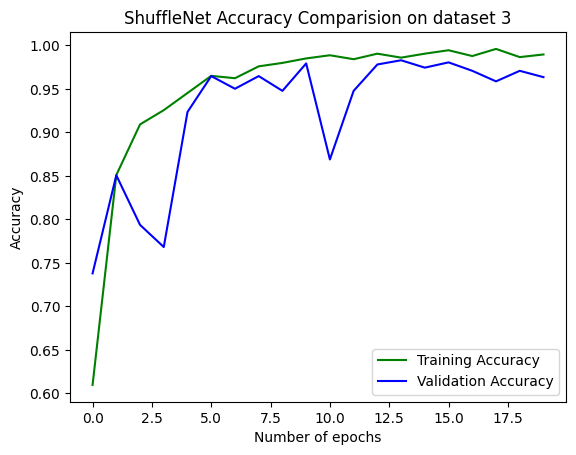

In [65]:
import matplotlib.pyplot as plt
from google.colab import files
fig,ax=plt.subplots()
ax.plot(epochs_list,training_accuracy_list,'g',label='Training Accuracy')
ax.plot(epochs_list,validation_accuracy_list,'b',label='Validation Accuracy')
ax.plot()
ax.set_title('ShuffleNet Accuracy Comparision on dataset 3')
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Accuracy')
ax.legend()
plt.savefig('Dataset3_ShuffleNet_Accuracy3.png')
files.download('Dataset3_ShuffleNet_Accuracy3.png')
plt.show()